**10.7 [Computational] MCMC.** Setting up a basic Markov chain Monte Carlo is quite straightforward, as you will now demonstrate. Use the same dataset as in Problem 10.5, with four measurements with uncorrelated error bars, and consider the same model as there,
$y = mx$ (model 1).

**a)** Set up the MCMC algorithm in the single parameter m and run it for some reasonably large number of steps (say, 10,000). [If you wish, you can look up the Gelman-Rubin convergence criterion and track it as well.]

**b)** Report the acceptance rate of your chain. If the value is either far too large or too small (relative to the optimal rate of ballpark 0.25), then change the stepsize accordingly, repeat the MCMC run, and see if the acceptance rate improves.


**c)** Plot the posterior in m. Find the best-fit value of this parameter, and its 68% credible interval.


**d)** Calculate the Bayesian evidence of your model,
$$P(D|model)=\int \mathcal{L}(D|m)P(m)dm$$
Note that you should use the properly normalized prior so that
$$\int P(m)dm = 1$$
Adopt the range $m \in [0, 5]$, and a uniform prior so that $P (m) = const. [Note, it might be easiest to not use your MCMC calculation, but rather calculate the evidence directly by summing on a grid in m. ]

**e)** Now consider a more complicated model:
$y = mx + b$ (model 2), with two free parameters, m and b. Calculate the Bayesian evidence of this model as well. You don’t need to run MCMC, just evaluate the evidence by summing on a grid of (m,b). Adopt the same m range as in part d), and the range $b=[-2, 2]$. And a uniform prior as before, normalized as $$\int P(m)dmdb = 1$$
Then evaluate the Bayes factor
$$B_{21} = \frac{P(D|model 2)}{P(D|model 1)} = \frac{\int \mathcal{L}(D|m)P(m)dmdb}{\int \mathcal{L}(D|m)P(m)dm}$$
where the numerator and the denominator are the Bayesian evidences for the two models respectively. With your result for $B_{21}$, use the Jeffreys scale (Table 10.1) to assess if the data prefer model 2 over model 1.

Dataset: 
$$y(x=1)= 2.0 \pm 1.0$$
$$y(x=2)= 4.0 \pm 2.0$$
$$y(x=3)= 6.0 \pm 3.0$$
$$y(x=4)= 8.0 \pm 4.0$$
Assume these four measurements are independent and identically distributed and that each comes from a Gaussian distribution.


Below is pseudocode for the Metropolis-Hastings MCMC algorithm in Figure 10.6 in Huterer:

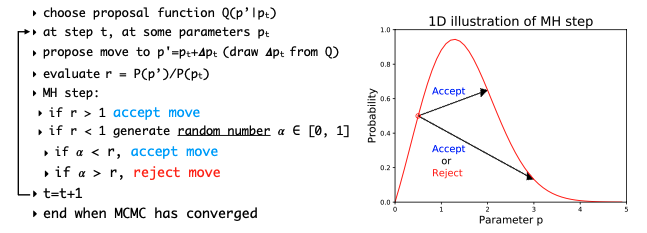

In [143]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from numpy import random
from scipy import stats as st
from scipy.integrate import quad

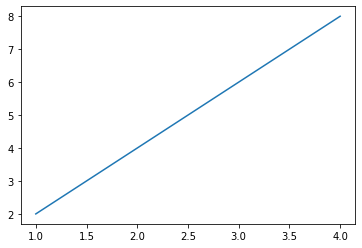

In [106]:
#dataset
xs = [1.0, 2.0, 3.0, 4.0]
ys = [2.0, 4.0, 6.0, 8.0] #how to include error bars?
plt.plot(xs, ys)
data=np.array(list(zip(xs, ys)), dtype=[('x',float),('y',float)])

x and y appear to have a linear relationship, hence why we pick y=mx as our model

Part A:

In [109]:
# using sigma = x for variance (width of Gaussian dist) since problem does not specify
def likelihood(p, data):
    chi_squared_sum = 0
    for row in data:
        x = row['x']
        y_data = row['y']
        y_model = p * x
        chi_squared_sum+=(y_model - y_data)**2/x**2
    #return chi_squared_sum
    likelihood = np.exp(-1*(chi_squared_sum**2)/2)
    return likelihood
        
        

In [110]:
likelihood(2.5, data)

0.6065306597126334

In [111]:
# TODO: HOW TO CALCULATE POSTERIOR PROBABILITY
def posterior_prob(p):
    
    return posterior
    


In [112]:
# initialization

steps = 10000 #10,000 steps
p_0 = random.uniform(low=0.0, high=5.0) #choose an initial value for p within the range for p
states = [p_0] #add initial p to states
accepted = 0
print(states)
posterior_m = [likelihood(p_0, data)]

for t in range(steps):
    # TODO: BURN IN?
    
    p_current = states[-1] #grab most recent value in states
    p_new = random.normal(loc=p_current, scale = 1.75) # generate a candidate p' for the next sample (using random.normal for Q)
    # because p has a uniform probability distribution from 0 to 5, the prior is constant
    # therefore, the ratio of the posteriors is equal to the ratio of the likelihoods
    likelihood_p_new = likelihood(p_new, data)
    posterior_m.append(likelihood_p_new)
    r = likelihood_p_new/likelihood(p_current, data)
    
    if r >= 1: 
        states.append(p_new)
        accepted += 1
    elif r < 1:
        alpha = random.rand()
        if r > alpha:
            states.append(p_new)
            accepted += 1
        else: states.append(p_current)
    
    
states = states[1000:]

[0.5180191722263755]


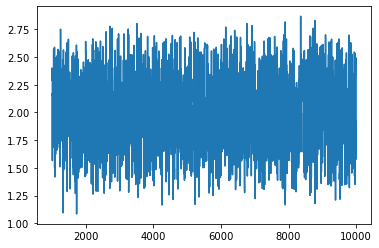

In [113]:
plt.plot(np.arange(1000, 10001), states)

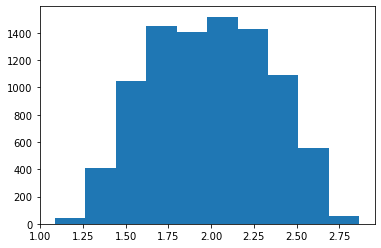

In [123]:
freq, bins, _ = plt.hist(states)

In [127]:
# print MCMC predicted value of m (peak of the histogram)
m_MCMC = bins[np.where(freq == freq.max())][0]
print(m_MCMC)

1.9763547047765868


Part B:

In [105]:
# print acceptance rate
print(f'Acceptance rate: {accepted/steps}')

Acceptance rate: 0.2465


Part C:

(0.99999, 1.0)

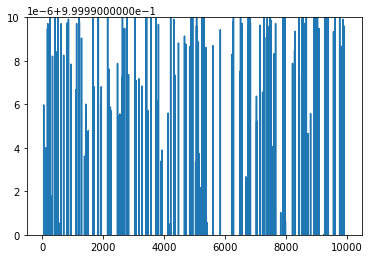

In [152]:
# Plot the posterior in m. Find the best-fit value of this parameter, and its 68% credible interval.

# save p_new, posterior(p_new) in a list as I go over the t's 
# plot posterior(p_new) vs p_new here

plt.plot(np.arange(0, 10001), posterior_m)
plt.ylim(0.99999,1)

Part D:

In [146]:
def bayesian_evidence(data):
    lik = lambda m: likelihood(m, data)
    integral = quad(lik, 0, 5) # uniform prior so prior const
    print(integral[0])
    

In [147]:
bayesian_evidence(data)

1.0779002747704651


In [137]:
# Calculate Bayesian evidence
ms = np.mgrid[0:5] # change this to np.meshgrid for more control?
print(ms)

[0 1 2 3 4]


Part E:

In [139]:
#y=mx+b
m_b_grid = np.mgrid[0:5, -2:2]
print(m_b_grid)

[[[ 0  0  0  0]
  [ 1  1  1  1]
  [ 2  2  2  2]
  [ 3  3  3  3]
  [ 4  4  4  4]]

 [[-2 -1  0  1]
  [-2 -1  0  1]
  [-2 -1  0  1]
  [-2 -1  0  1]
  [-2 -1  0  1]]]
